In [66]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce
from helpers import *
import numpy as np
from scipy.optimize import curve_fit
import tifffile
from sklearn.linear_model import LinearRegression


In [67]:
# Define a 2D Gaussian model
def two_d_gaussian(coords, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = coords
    xo = float(x0)
    yo = float(y0)
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
    c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
    g = offset + amplitude * np.exp(- (a * ((x - xo)**2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo)**2)))
    return g.ravel()

# Fit a 2D Gaussian to an image
def fit_gaussian_to_image(img):
    y_size, x_size = img.shape
    x = np.linspace(0, x_size - 1, x_size)
    y = np.linspace(0, y_size - 1, y_size)
    x, y = np.meshgrid(x, y)

    amplitude_guess = np.max(img)
    y0_guess, x0_guess = np.unravel_index(np.argmax(img), img.shape)
    sigma_x_guess = sigma_y_guess = 2.0
    theta_guess = 0
    offset_guess = np.median(img)

    initial_guess = (amplitude_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess, theta_guess, offset_guess)
    popt, _ = curve_fit(two_d_gaussian, (x, y), img.ravel(), p0=initial_guess, maxfev=2000)
    x0, y0 = popt[1], popt[2]
    return x0, y0

# Extract centroids from the images
def  get_centroids_1(images):
    centroids = []
    for img in images:
        x0, y0 = fit_gaussian_to_image(img)
        centroids.append((x0, y0))
    return np.array(centroids)

# Compute Mean Squared Displacement (MSD)
def compute_msd(positions, dt):
    N = positions.shape[0]
    msd = []
    time_lags = []
    for lag in range(1, N):
        diffs = positions[lag:] - positions[:-lag]
        squared_diffs = np.sum(diffs**2, axis=1)
        msd.append(np.mean(squared_diffs))
        time_lags.append(lag * dt)
    return np.array(time_lags), np.array(msd)

# Fit diffusion coefficient from MSD
def fit_diffusion_coefficient(time_lags, msd):
    model = LinearRegression(fit_intercept=False)
    model.fit(time_lags.reshape(-1, 1), msd)  # Fit model to data
    slope = model.coef_[0]
    D_estimated = slope / 4
    return D_estimated

def plot_images_with_centroids(images, centroids):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray', origin='lower')
        ax.scatter(centroids[i, 0], centroids[i, 1], color='red', s=10, label='Centroid')  # Reduced point size
        ax.set_title(f"Frame {i + 1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

### DANIEL BLOCK IMAGES

In [68]:

file_path = '/Users/mattice/Desktop/MLProject_BrowianMotion/ml-project-2-big-burger/real-data/blocks_64x64x16_70_01/block-001-6.658-0.057-456.tif'
images = tifffile.imread(file_path)
dt = 0.1  # seconds per frame

# Compute centroids, MSD, and diffusion coefficient
centroids =  get_centroids_1(images)
time_lags, msd = compute_msd(centroids, dt)
D_pixel_units = fit_diffusion_coefficient(time_lags, msd)


print("Centroids (pixels):", centroids)
print("Time Lags (s):", time_lags)
print("MSD (pixels^2):", msd)
print("Diffusion Coefficient D (pixels^2/s):", D_pixel_units)


Centroids (pixels): [[31.47099448 31.32949638]
 [31.59255559 32.1890121 ]
 [31.17773527 31.80919774]
 [31.2513118  29.39675575]
 [31.39305183 30.65565563]
 [32.26339492 31.04295683]
 [30.87780936 32.57972818]
 [28.79158851 32.19539244]
 [30.5352007  33.78194489]
 [31.60816    33.85112603]
 [31.98506452 32.61951235]
 [31.51624651 32.57325196]
 [31.5273211  32.58478512]
 [33.30786687 31.97312632]
 [34.35599761 30.04150226]
 [33.85097422 29.9393301 ]]
Time Lags (s): [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
MSD (pixels^2): [ 2.36155431  5.05024466  6.41841359  6.49150812  8.31920094 11.09308155
 11.23446526  9.50563498  6.32149422  4.42789246  4.57669551  6.21163811
  8.89312716 10.07184784  7.59686586]
Diffusion Coefficient D (pixels^2/s): 1.8490914087300039


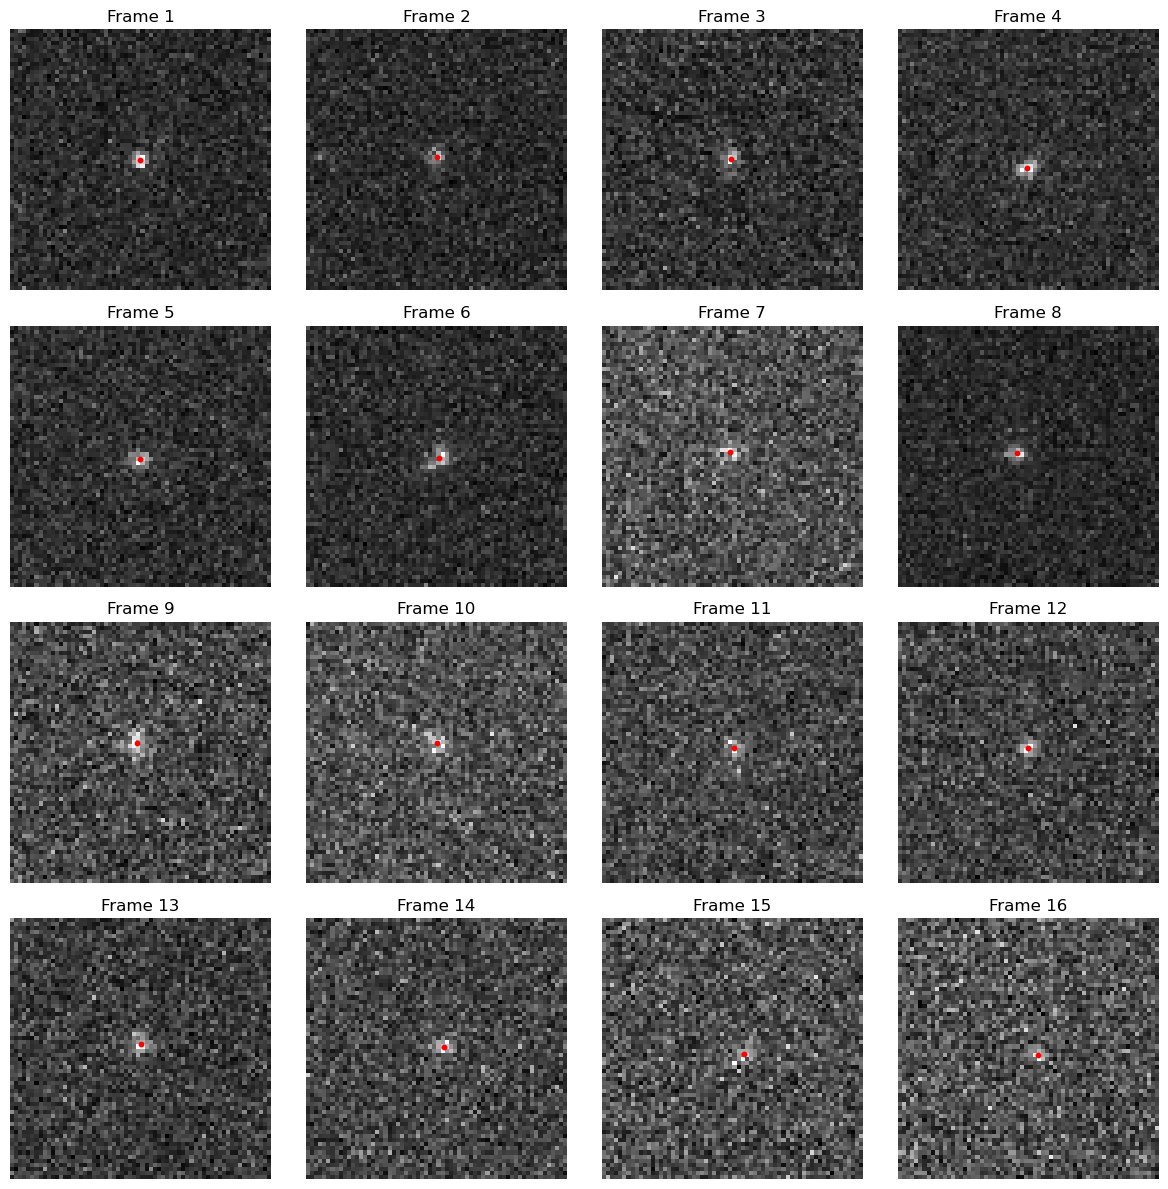

In [69]:

plot_images_with_centroids(images, centroids)


###  IMAGES GENEREES

Generating trajectories: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

running program on each 11 cpu core of the computer



Generating images and estimating D: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


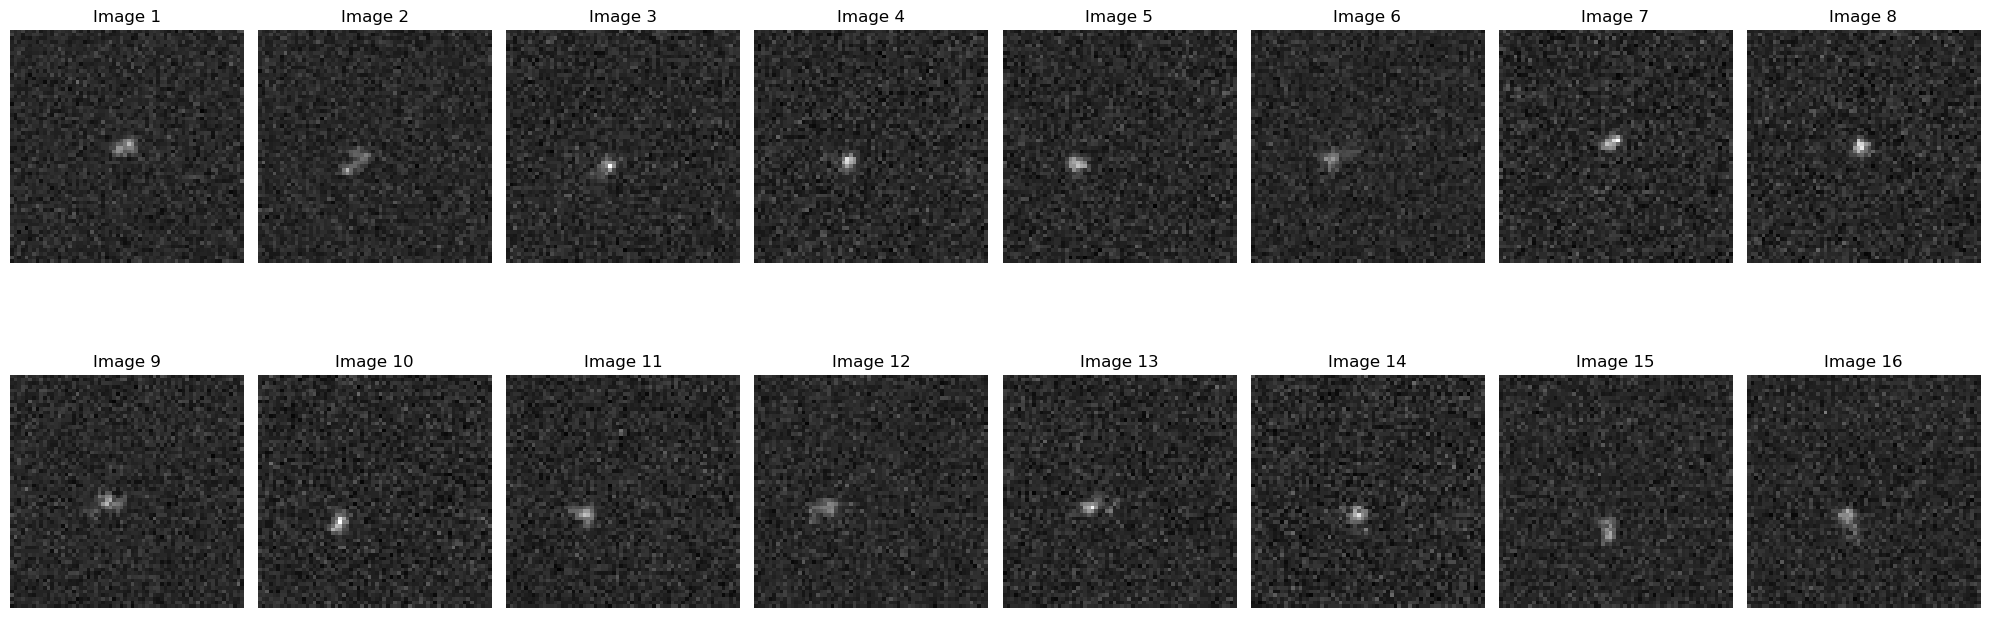

In [70]:

### Parameters for the simulation and image generation
nframes = 16    # number of frames
nposframe = 10
dt = 0.01        # seconds between frames
DGen = 20000     # diffusion coefficient in nm^2/s
npixel = 64
pixelsize = 100  # nm per pixel
fwhm_psf = 200   # nm
factor_hr = 5
flux = 100
poisson_noise = 100
gaussian_noise = 10
background = 100
normalizeValue = 1000



# Generate images and ground truth data
images_arr, estimatedDs = generateImagesAndEstimateDMAXD(
    1, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize, flux, background, 
    poisson_noise, gaussian_noise, normalizeValue
)
images = images_arr[0]

# Display the first 16 images
global_min_gen = np.min(images)
global_max_gen = np.max(images)
num_images = min(16, len(images))
rows, cols = 2, 8
plt.figure(figsize=(20, 8))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i], cmap="gray", vmin=global_min_gen, vmax=global_max_gen)
    plt.title(f"Image {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [71]:
# Compute centroids, MSD, and diffusion coefficient
centroids = get_centroids_1(images)   # shape: (nframes, 2)
time_lags, msd = compute_msd(centroids, dt)
D_pixel_units = fit_diffusion_coefficient(time_lags, msd)

# Convert D from pixels^2/s to nm^2/s if desired
# Since 1 pixel = pixelsize nm, D_nm = D_pixel_units * (pixelsize^2)
D_nm_s = D_pixel_units * (pixelsize**2)

# Print results
print("Centroids (pixels):", centroids)
print("Time Lags (s):", time_lags)
print("MSD (pixels^2):", msd)

print("Diffusion Coefficient D (pixels^2/s):", D_pixel_units)
print("Diffusion Coefficient D centroids (nm^2/s):", D_nm_s/400000)
print('from trajectory',estimatedDs/1000)

Centroids (pixels): [[31.06279739 31.67718666]
 [26.19629649 36.25089535]
 [27.53145936 36.91070576]
 [25.33622568 35.73068287]
 [19.79242156 36.39021867]
 [21.65726482 35.08846315]
 [30.48865224 30.4618397 ]
 [30.55928933 31.70376255]
 [26.58703981 34.46037141]
 [21.75971391 40.1840465 ]
 [21.18814152 37.85610899]
 [19.31798625 36.0851847 ]
 [23.53845273 35.89921122]
 [28.69937285 37.96890697]
 [29.5183908  42.41243812]
 [27.02460535 38.67230454]]
Time Lags (s): [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15]
MSD (pixels^2): [24.76855625 55.83089599 72.2091736  70.69089482 50.69133272 31.40155673
 29.68085198 52.17283381 76.37866737 64.80466984 57.33828383 32.34473217
 32.51085709 62.09006682 65.23866917]
Diffusion Coefficient D (pixels^2/s): 127.57320191018536
Diffusion Coefficient D centroids (nm^2/s): 3.1893300477546345
from trajectory [3.81488702]


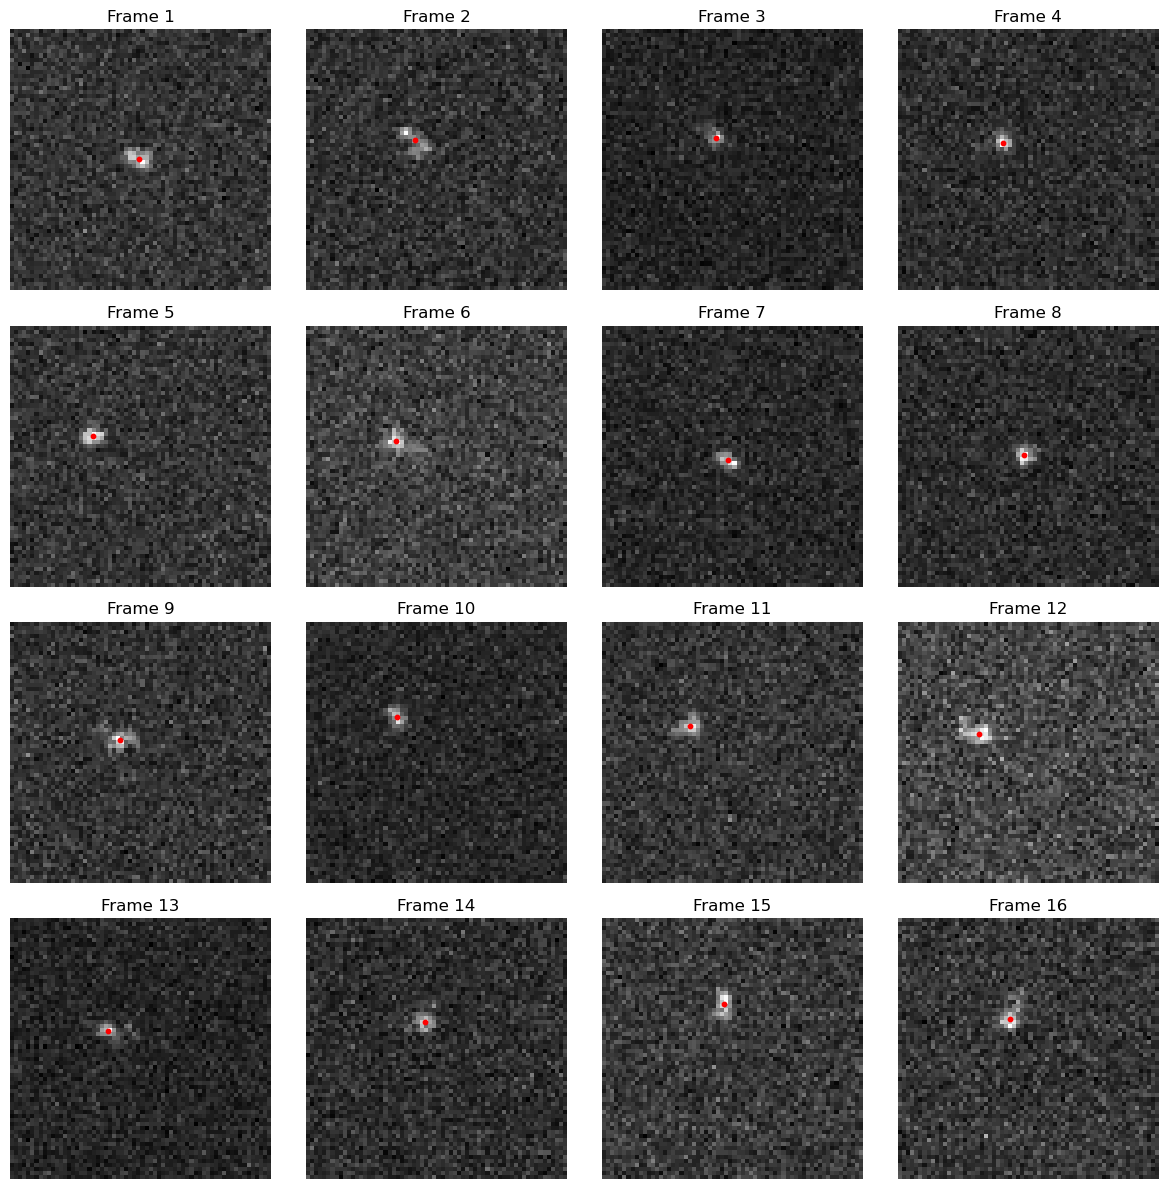

In [72]:

plot_images_with_centroids(images, centroids)

### DUMMY TRAJECTOIRES test sur 1

In [ ]:

from scipy.ndimage import gaussian_filter



# Fit a 2D Gaussian to an image
def fit_gaussian_to_image(img, pixelsize, fwhm_psf):
    y_size, x_size = img.shape
    x = np.linspace(0, x_size - 1, x_size)
    y = np.linspace(0, y_size - 1, y_size)
    x, y = np.meshgrid(x, y)

    amplitude_guess = np.max(img)
    y0_guess, x0_guess = np.unravel_index(np.argmax(img), img.shape)
    sigma_x_guess = sigma_y_guess = fwhm_psf / pixelsize / 2.355  # Convert PSF FWHM to std. dev
    theta_guess = 0
    offset_guess = np.min(img)

    initial_guess = (amplitude_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess, theta_guess, offset_guess)
    try:
        popt, _ = curve_fit(two_d_gaussian, (x, y), img.ravel(), p0=initial_guess, maxfev=2000)
        x0, y0 = popt[1], popt[2]
    except RuntimeError:
        print("Gaussian fit failed for this frame.")
        x0, y0 = np.unravel_index(np.argmax(img), img.shape)  # Fallback: Max intensity

    return x0, y0, popt if 'popt' in locals() else None

# Visualize the Gaussian fit
def visualize_fit(img, popt):
    y_size, x_size = img.shape
    x = np.linspace(0, x_size - 1, x_size)
    y = np.linspace(0, y_size - 1, y_size)
    x, y = np.meshgrid(x, y)
    fit = two_d_gaussian((x, y), *popt).reshape(y_size, x_size)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img, cmap="gray")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title("Gaussian Fit")
    plt.imshow(fit, cmap="gray")
    plt.colorbar()
    plt.show()

# Extract centroids from the images
def get_centroids(images, pixelsize, fwhm_psf):
    centroids = []
    for img in images:
        img_smoothed = gaussian_filter(img, sigma=1)  # Apply noise reduction
        x0, y0, popt = fit_gaussian_to_image(img_smoothed, pixelsize, fwhm_psf)
        centroids.append((x0, y0))

        if popt is not None:
            visualize_fit(img_smoothed, popt)  # Visualize the fit for debugging

    return np.array(centroids)

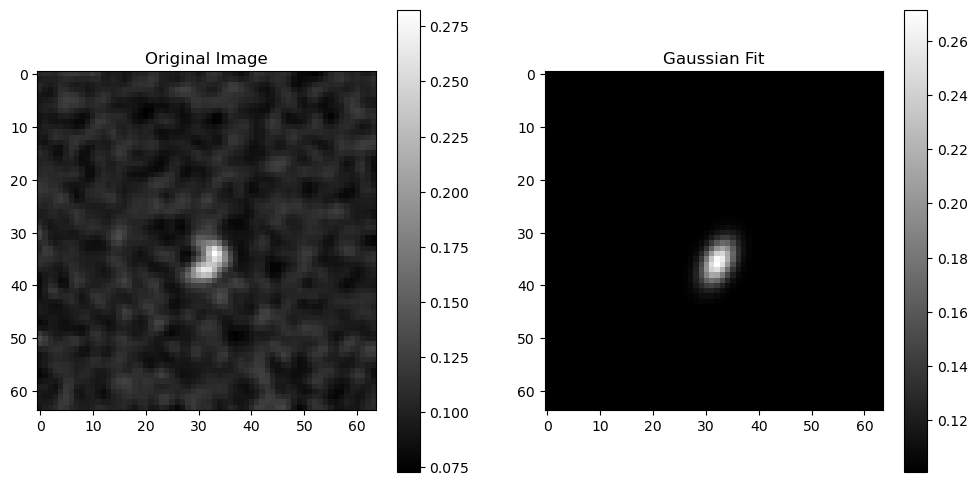

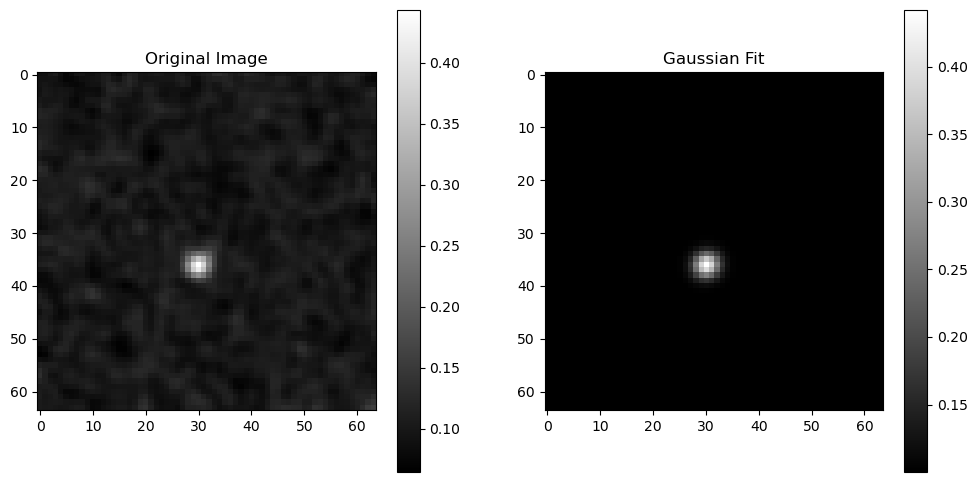

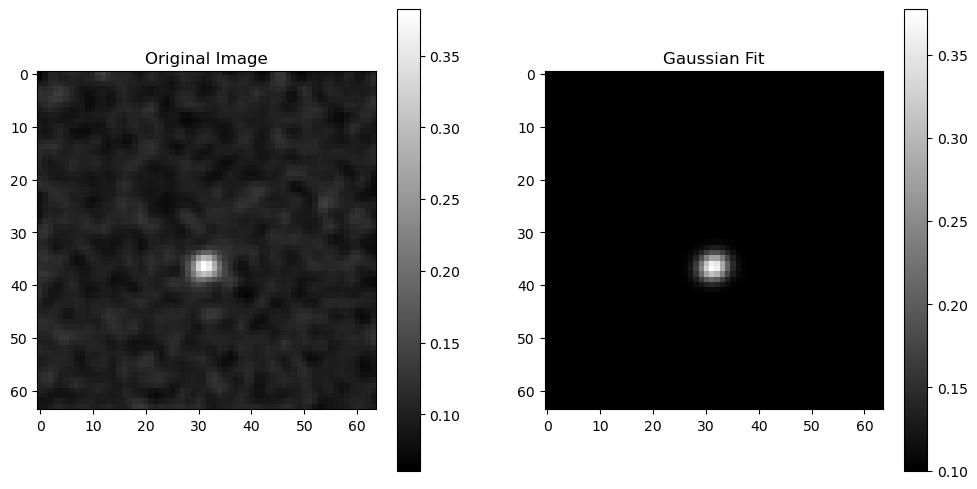

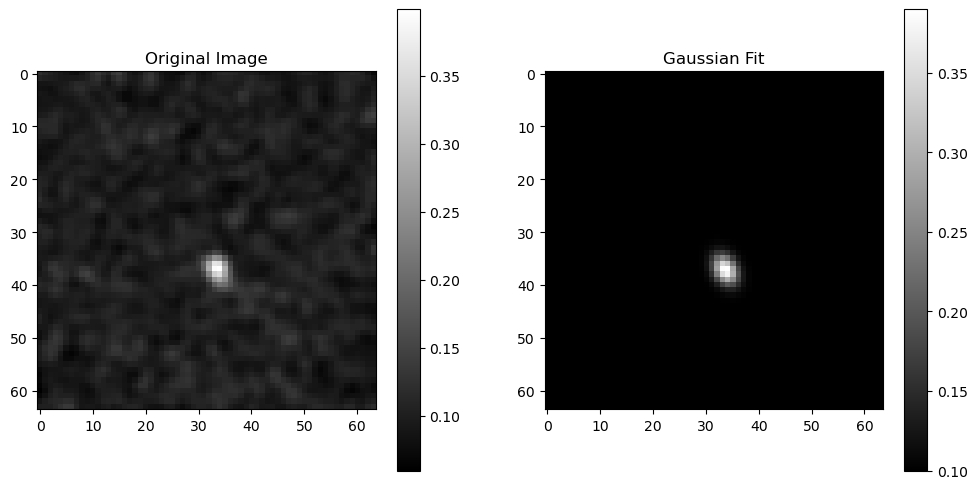

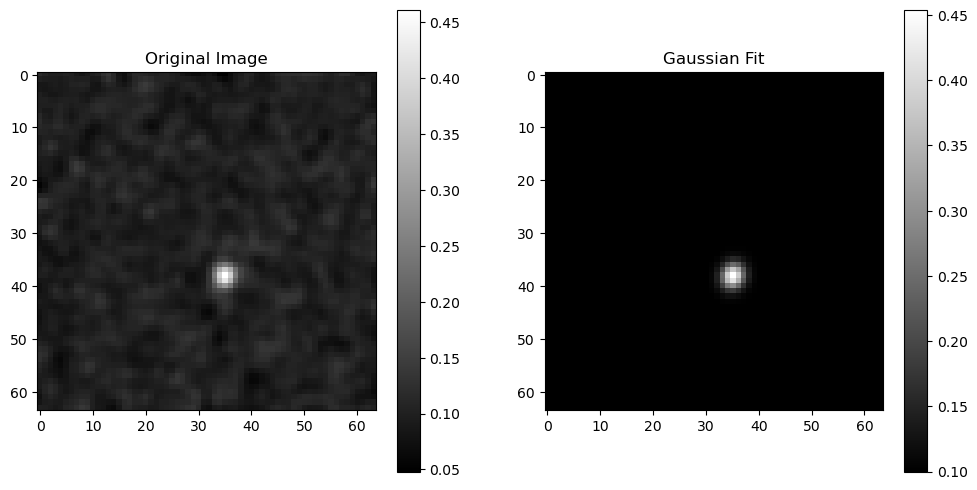

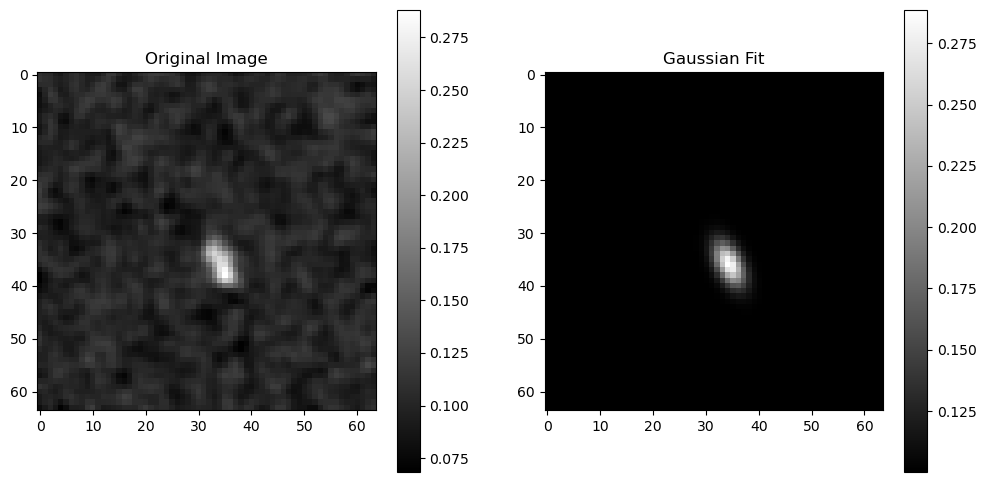

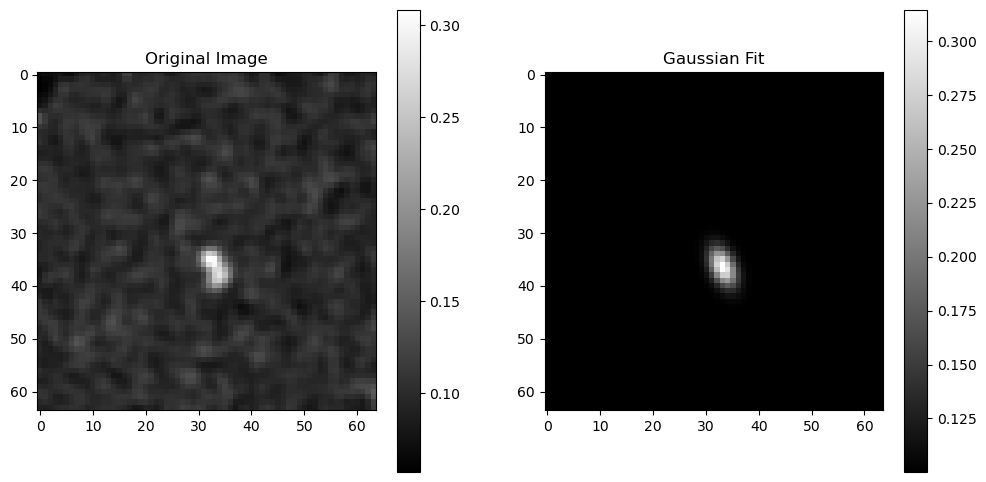

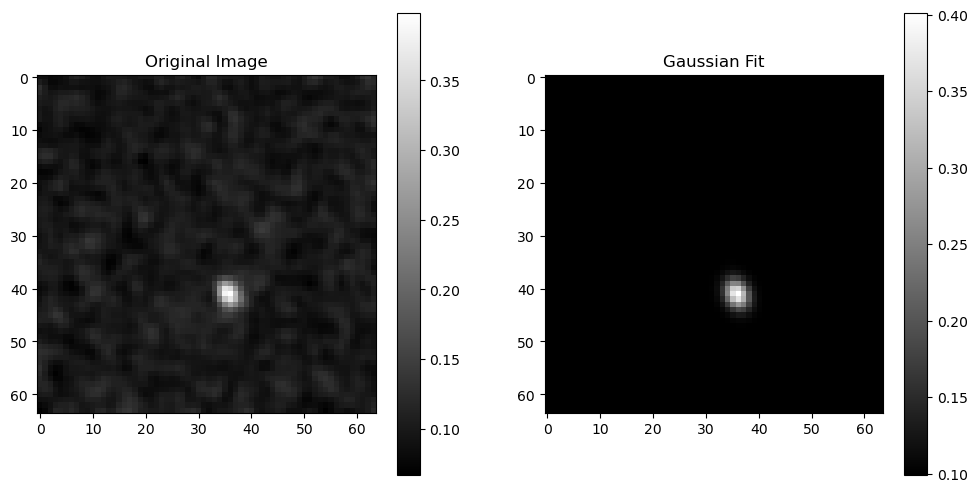

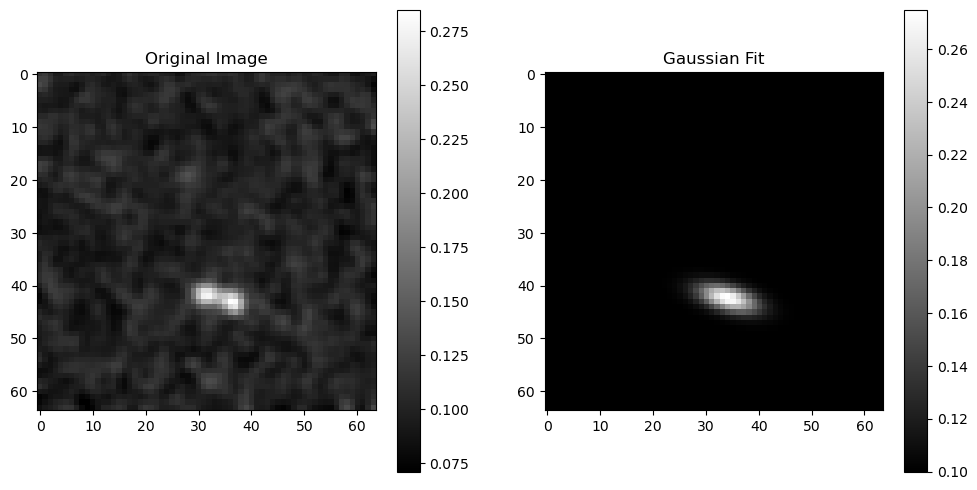

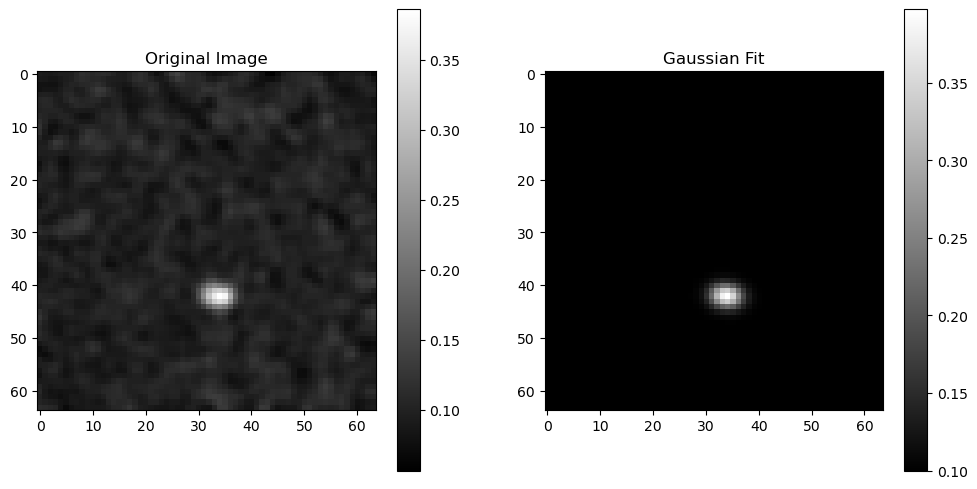

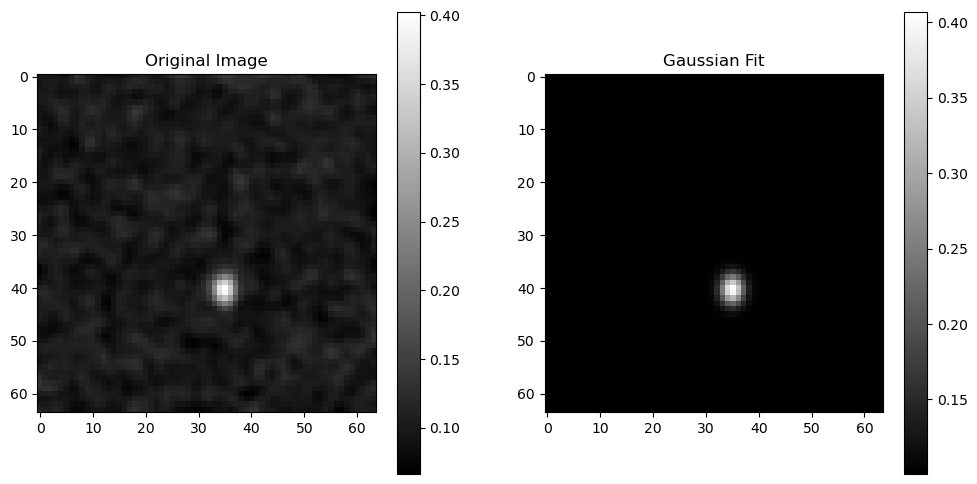

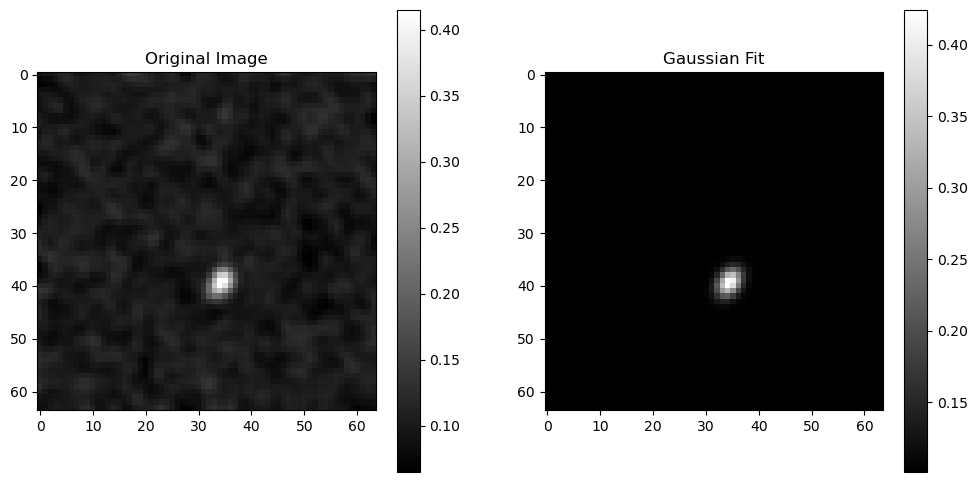

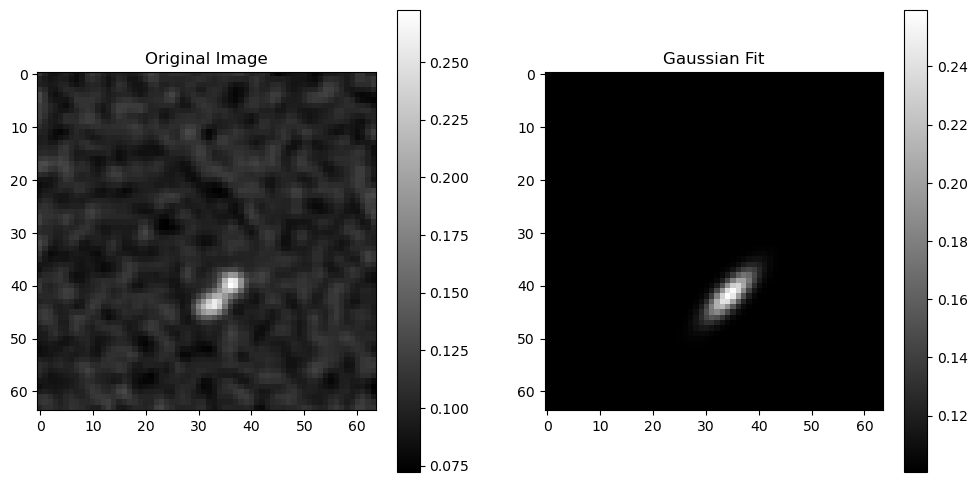

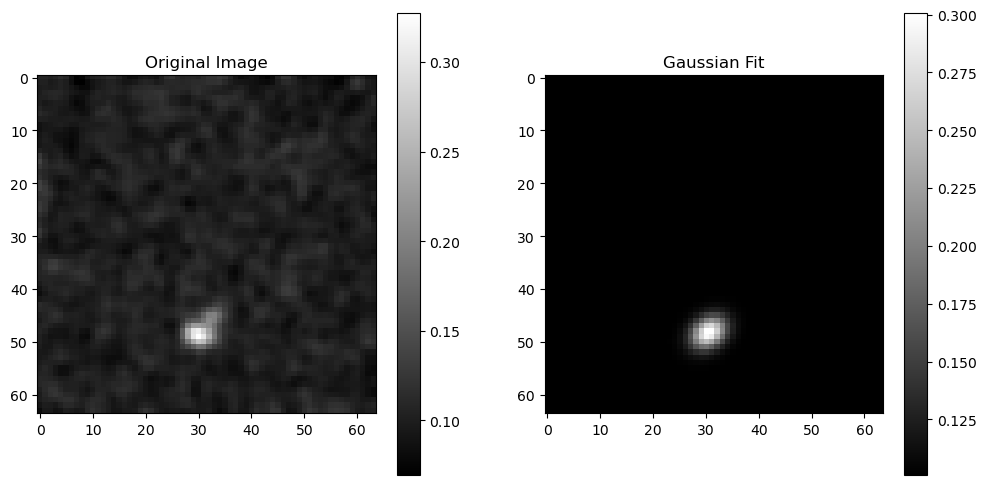

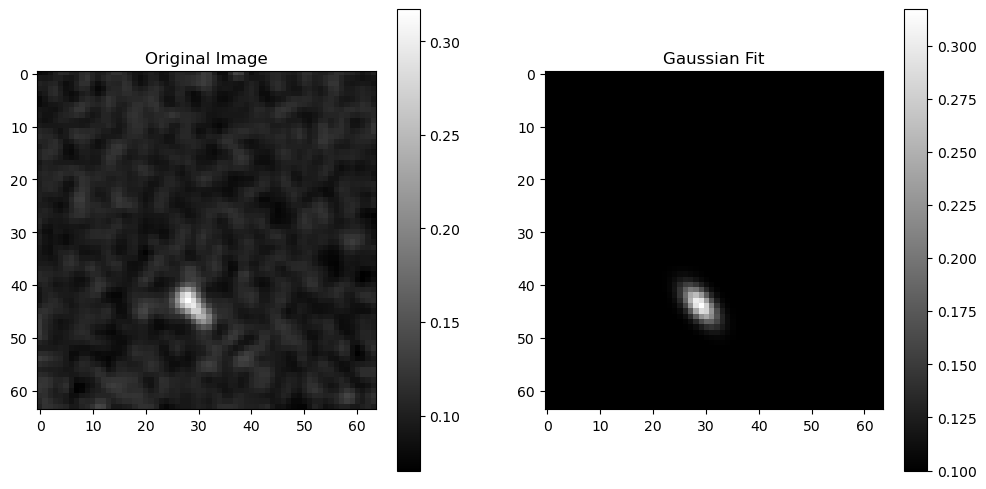

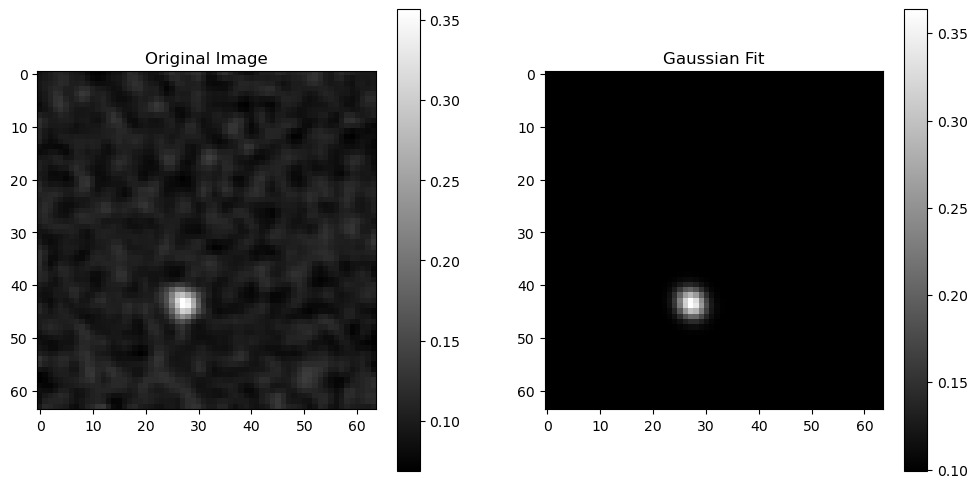

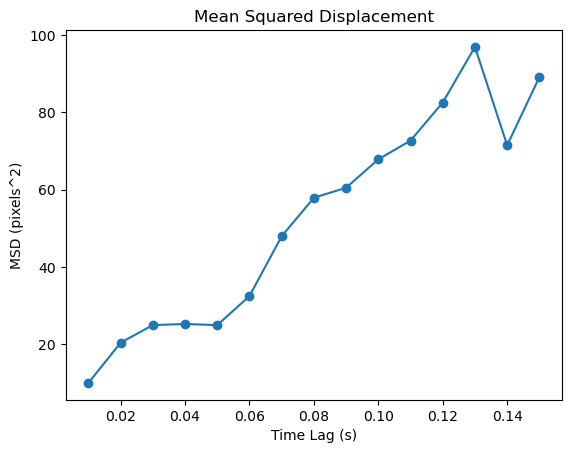

Centroids (pixels): [[32.16542431 35.56788185]
 [29.99724103 36.12262189]
 [31.2862952  36.64572952]
 [33.57592182 37.21947326]
 [34.99124814 38.17935839]
 [34.30159146 35.95090008]
 [33.10551035 36.51014771]
 [35.76176545 41.05889473]
 [34.06528463 42.40552645]
 [33.74702935 41.97342901]
 [34.85948908 40.3615953 ]
 [34.31654023 39.41478452]
 [34.41223446 41.68663126]
 [30.41661177 48.29797359]
 [28.77768897 43.81469672]
 [27.14463748 43.56094096]]
Time Lags (s): [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15]
MSD (pixels^2): [10.0493752  20.46250982 24.99817892 25.28957534 24.98748613 32.52084532
 47.97181295 57.92251311 60.5085699  67.85483638 72.69164182 82.54128447
 96.91412717 71.47632194 89.09729441]
Diffusion Coefficient D (pixels^2/s): 160.41558617244127
Diffusion Coefficient D (nm^2/s): 4.010389654311032
Diffusion COefficient D from our estimation 4.5225523190031405


In [ ]:

DGen = 10000    
n_val_im = 50
val_trajs = np.load('/Users/mattice/Desktop/MLProject_BrowianMotion/ml-project-2-big-burger/validation_trajectories.npy')
val_images, valDs = generateImagesAndEstimateDFromTrajs(val_trajs,n_val_im, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
images = val_images[4]

# Compute centroids, MSD, and diffusion coefficient
centroids = get_centroids(images, pixelsize, fwhm_psf)   # Shape: (nframes, 2)
time_lags, msd = compute_msd(centroids, dt)
D_pixel_units = fit_diffusion_coefficient(time_lags, msd)
D_nm_s = D_pixel_units * (pixelsize**2)

# Plot MSD
plt.plot(time_lags, msd, 'o-')
plt.xlabel("Time Lag (s)")
plt.ylabel("MSD (pixels^2)")
plt.title("Mean Squared Displacement")
plt.show()

# Print results
print("Centroids (pixels):", centroids)
print("Time Lags (s):", time_lags)
print("MSD (pixels^2):", msd)
print("Diffusion Coefficient D (pixels^2/s):", D_pixel_units)
print("Diffusion Coefficient D (nm^2/s):", D_nm_s/400000)
print("Diffusion COefficient D from our estimation",valDs[4]/1000)

# REDIFINIR IMPORTANT

In [74]:



# Fit a 2D Gaussian to an image
def fit_gaussian_to_image(img, pixelsize, fwhm_psf):
    y_size, x_size = img.shape
    x = np.linspace(0, x_size - 1, x_size)
    y = np.linspace(0, y_size - 1, y_size)
    x, y = np.meshgrid(x, y)

    amplitude_guess = np.max(img)
    y0_guess, x0_guess = np.unravel_index(np.argmax(img), img.shape)
    sigma_x_guess = sigma_y_guess = fwhm_psf / pixelsize / 2.355  # Convert PSF FWHM to std. dev
    theta_guess = 0
    offset_guess = np.min(img)

    initial_guess = (amplitude_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess, theta_guess, offset_guess)
    try:
        popt, _ = curve_fit(two_d_gaussian, (x, y), img.ravel(), p0=initial_guess, maxfev=2000)
        x0, y0 = popt[1], popt[2]
    except RuntimeError:
        print("Gaussian fit failed for this frame.")
        x0, y0 = np.unravel_index(np.argmax(img), img.shape)  # Fallback: Max intensity

    return x0, y0, popt if 'popt' in locals() else None

# Extract centroids from the images
def get_centroids(images, pixelsize, fwhm_psf):
    centroids = []
    for img in images:
        img_smoothed = gaussian_filter(img, sigma=1)  # Apply noise reduction
        x0, y0, popt = fit_gaussian_to_image(img_smoothed, pixelsize, fwhm_psf)
        centroids.append((x0, y0))
    return np.array(centroids)


Processing trajectory set 1
Diffusion Coefficient D (pixels^2/s): 33.005519711218646
Diffusion Coefficient D (nm^2/s): 0.8251379927804662
True Diffusion Coefficient D (nm^2/s): 0.9370403369150057
Processing trajectory set 2
Diffusion Coefficient D (pixels^2/s): 69.56873233983539
Diffusion Coefficient D (nm^2/s): 1.7392183084958848
True Diffusion Coefficient D (nm^2/s): 1.9546486538046934
Processing trajectory set 3
Diffusion Coefficient D (pixels^2/s): 116.4783433969124
Diffusion Coefficient D (nm^2/s): 2.91195858492281
True Diffusion Coefficient D (nm^2/s): 2.911942059622747
Processing trajectory set 4
Diffusion Coefficient D (pixels^2/s): 133.02999648293806
Diffusion Coefficient D (nm^2/s): 3.3257499120734515
True Diffusion Coefficient D (nm^2/s): 3.5336904046896622
Processing trajectory set 5
Diffusion Coefficient D (pixels^2/s): 160.41558617244127
Diffusion Coefficient D (nm^2/s): 4.010389654311032
True Diffusion Coefficient D (nm^2/s): 4.5225523190031405
Processing trajectory set 

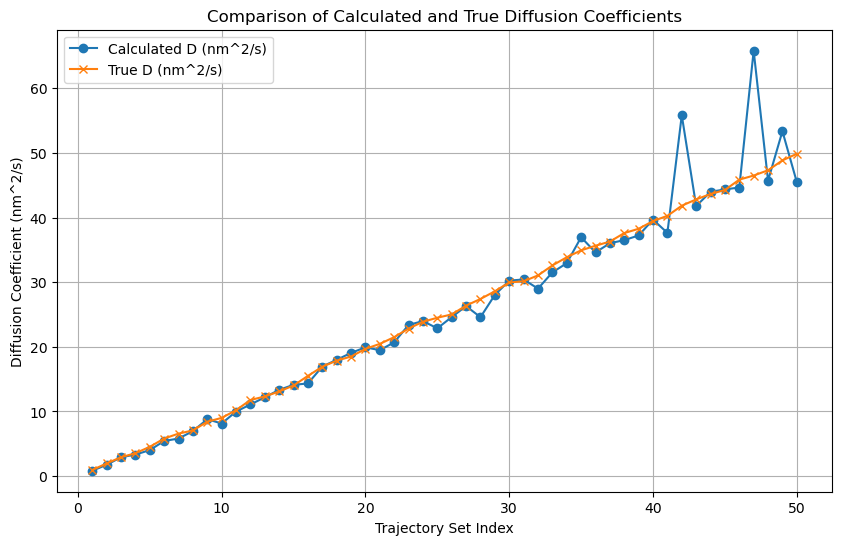

In [75]:


# Lists to store results
calculated_D_nm_s = []
true_D_nm_s = []
indices = []

# Process each trajectory set and collect results
for idx, (images, true_D) in enumerate(zip(val_images, valDs)):
    print(f"Processing trajectory set {idx + 1}")
    
    centroids = get_centroids(images, pixelsize, fwhm_psf)
    time_lags, msd = compute_msd(centroids, dt)
    D_pixel_units = fit_diffusion_coefficient(time_lags, msd)
    D_nm_s = D_pixel_units * (pixelsize**2)
    
    # Store results
    calculated_D_nm_s.append(D_nm_s/400000)
    true_D_nm_s.append(true_D / 1000)
    indices.append(idx + 1)
    
   
    print("Diffusion Coefficient D (pixels^2/s):", D_pixel_units)
    print("Diffusion Coefficient D (nm^2/s):", D_nm_s/400000)
    print("True Diffusion Coefficient D (nm^2/s):", true_D / 1000)


plt.figure(figsize=(10, 6))

plt.plot(indices, calculated_D_nm_s, label="Calculated D (nm^2/s)", marker='o')
plt.plot(indices, true_D_nm_s, label="True D (nm^2/s)", marker='x')

plt.xlabel("Trajectory Set Index")
plt.ylabel("Diffusion Coefficient (nm^2/s)")
plt.title("Comparison of Calculated and True Diffusion Coefficients")
plt.legend()
plt.grid(True)

plt.show()


In [76]:

# Compute the ratio for each trajectory set
ratios = [calc / true for calc, true in zip(calculated_D_nm_s, true_D_nm_s)]

# Check for consistency
for i, ratio in enumerate(ratios):
    print(f"Trajectory set {i + 1}: Ratio = {ratio}")

# Summary statistics
mean_ratio = sum(ratios) / len(ratios)
print(f"Mean Ratio: {mean_ratio}")
print(f"Standard Deviation of Ratios: {sum((r - mean_ratio) ** 2 for r in ratios) ** 0.5 / len(ratios)}")


Trajectory set 1: Ratio = 0.8805789465766727
Trajectory set 2: Ratio = 0.8897856426066767
Trajectory set 3: Ratio = 1.000005675009916
Trajectory set 4: Ratio = 0.9411548639517919
Trajectory set 5: Ratio = 0.886753623050402
Trajectory set 6: Ratio = 0.9353303569295836
Trajectory set 7: Ratio = 0.8836863115312568
Trajectory set 8: Ratio = 0.9848434760913716
Trajectory set 9: Ratio = 1.046580887483093
Trajectory set 10: Ratio = 0.9030383060250827
Trajectory set 11: Ratio = 0.9797131200898866
Trajectory set 12: Ratio = 0.9408864618207664
Trajectory set 13: Ratio = 0.9892942054396198
Trajectory set 14: Ratio = 1.019279118545729
Trajectory set 15: Ratio = 1.0072683638284459
Trajectory set 16: Ratio = 0.924287091491891
Trajectory set 17: Ratio = 1.001481832979585
Trajectory set 18: Ratio = 1.0069146467216017
Trajectory set 19: Ratio = 1.0305934762801932
Trajectory set 20: Ratio = 1.0122248657031947
Trajectory set 21: Ratio = 0.952219950810468
Trajectory set 22: Ratio = 0.9627660169469091
Traj